# Приоретизация и проверка гипотез маркетингового отдела интернет-магазина

**Описание проекта**

Отдел маркетинга подготовил список гипотез для увеличения выручки. Требуется их приоритизировать, запустить A/B-тест и проаналировать результаты.

<b> Цели и задачи </b> 

- Анализ A/B-теста
- Приоретизация и проверка гипотез
- Принятие решения о продолжении или остановке теста

<b> Описание данных </b>

В нашем распоряжении три датасета.  
- `hypothesis.csv` — содержит информацию о 9 гипотезах по увеличению выручки интернет-магазина;
- `orders.csv` — содержит информацию о заказах;
- `visitors.csv` — информацию о посетителях.

Структура `hypothesis.csv`:  
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура `orders.csv`:  
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Структура `visitors.csv`:  
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

<b> План анализа данных </b> 

[Загрузка и предобработка данных](#0)

[Часть 1. Приоритизация гипотез](#1)  
  - [Применяем фреймворк ICE для приоритизации гипотез](#1.1)  
  - [Применяем фреймворк RICE для приоритизации гипотез](#1.2)  
  - [Указываем, как изменилась приоритизация гипотез при применении RICE вместо ICE](#1.3)
  
[Часть 2. Анализ A/B-теста](#2)  
  - [Строим график кумулятивной выручки по группам](#2.1)
  - [Строим график кумулятивного среднего чека по группам](#2.2)
  - [Строим график относительного изменения кумулятивного среднего чека группы B к группе A](#2.3)
  - [Строим график кумулятивного среднего количества заказов на посетителя по группам](#2.4)
  - [Строим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A](#2.5)
  - [Строим точечный график количества заказов по пользователям](#2.6)
  - [Считаем 95-й и 99-й перцентили количества заказов на пользователя. Определяем границу аномальных пользователей](#2.7)
  - [Строим точечный график стоимостей заказов](#2.8)
  - [Считаем 95-й и 99-й перцентили стоимости заказов. Определяем границу аномальных пользователей](#2.9)
  - [Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным](#2.10)
  - [Считаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным](#2.11)
  - [Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным](#2.12)
  - [Считаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным](#2.13)
  - [Принимаем решение по результатам теста](#2.14)
  
[Вывод](#3)

### Загрузка и предобработка данных <a id='0'></a>

In [1]:
#импортируем библиотеки
import os
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_df(file_name:str, sep=','):
    '''Функция получения датасета.  
    
    Пытается получить датасет из трех директорий:  
    - из текущей папки;  
    - из папки `datasets`;  
    - из папки `../datasets`.'''
    path_1 = os.path.join('datasets', file_name)
    path_2 = os.path.join('../datasets', file_name)
    if os.path.exists(file_name):
        df = pd.read_csv(file_name, sep=sep)
        return df
    elif os.path.exists(path_1):
        df = pd.read_csv(path_1, sep=sep)
        return df
    elif os.path.exists(path_2):
        df = pd.read_csv(path_2, sep=sep)
        return df
    else:
        print('File is not found')

In [3]:
hypothesis, orders, visitors = (
    get_df('hypothesis.csv'),
    get_df('orders.csv'),
    get_df('visitors.csv')
)

In [4]:
#смотрим на датасеты
datasets = [hypothesis, orders, visitors]
for i in datasets:
    display(i.head(5))
    display(i.info())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

In [5]:
#приведем названия колонок к нижнему регистру, столбцы с датами переведем в формат datetime
hypothesis.columns = hypothesis.columns.str.lower()
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [6]:
#проверяем данные на дубликаты и пропуски
for i in datasets:
    display(i.duplicated().sum())
    display(i.isna().sum())

0

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

0

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

0

date        0
group       0
visitors    0
dtype: int64

Дубликатов и пропусков нет

In [7]:
#зафиксируем изначальное количество строк датафрейма orders
orders_shape = orders.shape[0]

#группируем данные по visitorId и group
grouped_orders = orders.groupby(['visitorId', 'group']).size().reset_index(name='count')

#находим пользователей, которые присутствуют в обеих группах
duplicated_visitors = grouped_orders[grouped_orders.duplicated(subset='visitorId', keep=False)]

#удаляем строки
orders = orders[~orders['visitorId'].isin(duplicated_visitors['visitorId'])]

#вывод
'Удалено строк: {}'.format(orders_shape - orders.shape[0]) 

'Удалено строк: 181'

Данные собраны некорректно. Удалили 181 строку с заказами, т.к. пользователи, совершившие их, попали в обе группы эксперимента. 

### Часть 1. Приоритизация гипотез.<a id='1'></a>

In [8]:
#создадим столбцы ice и rice для приоритизации гипотез
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis['ice'] = hypothesis.impact * hypothesis.confidence / hypothesis.efforts
hypothesis['rice'] = hypothesis.reach * hypothesis.impact * hypothesis.confidence / hypothesis.efforts

#### 1.1 Применяем фреймворк ICE для приоритизации гипотез. <a id='1.1'></a>

In [9]:
pd.set_option('display.max_colwidth', 100)

In [10]:
#посмотрим на приоритизацию с применением метода ICE
hypothesis[['hypothesis','ice']].sort_values('ice', ascending=False).style.background_gradient(subset=['ice'], 
                                                                                               cmap='BuGn', 
                                                                                               low=0.7, 
                                                                                               high=1.5)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


#### 1.2 Применяем фреймворк RICE для приоритизации гипотез. <a id='1.2'></a>

In [11]:
#посмотрим на приоритизацию с применением метода RICE
hypothesis[['hypothesis','rice']].sort_values('rice', ascending=False).style.background_gradient(subset=['rice'], 
                                                                                                 cmap='PuBuGn', 
                                                                                                 low=0.1, 
                                                                                                 high=1.5)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000000


#### 1.3 Указываем, как изменилась приоритизация гипотез при применении RICE вместо ICE <a id='1.3'></a>

Формулы методов приоретизации гипотез:

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

С применением приоритизации гипотез методом ICE самой приоритетной становится гипотеза №8. С применением метода RICE - гипотеза №7, гипотеза №8 в этом случае занимает пятое место по значимости. Так происходит, потому что в метод RICE добавляется параметр reach (охват). У гипотезы №8 он равен 1, это значит, что гипотеза охватывает минимальное количество пользователей.

В данном случае самой приоритетной для проверки является гипотеза №7

### Часть 2. Анализ A/B-теста.<a id='2'></a>

#### 2.1 Строим график кумулятивной выручки по группам. <a id='2.1'></a>

In [12]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = (datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])]
                                      .agg({'date' : 'max', 
                                            'group' : 'max', 
                                            'transactionId' : 'nunique', 
                                            'visitorId' : 'nunique', 
                                            'revenue' : 'sum'}
                                          ), axis=1
                                     ).sort_values(by=['date','group'])
                   )

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = (datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                         visitors['group'] == x['group'])]
                                        .agg({'date' : 'max', 
                                              'group' : 'max', 
                                              'visitors' : 'sum'}
                                            ), axis=1
                                       ).sort_values(by=['date','group'])
                     )

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, 
                                        left_on=['date', 'group'], 
                                        right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [13]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders', 'buyers', 'visitors']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders', 'buyers', 'visitors']]

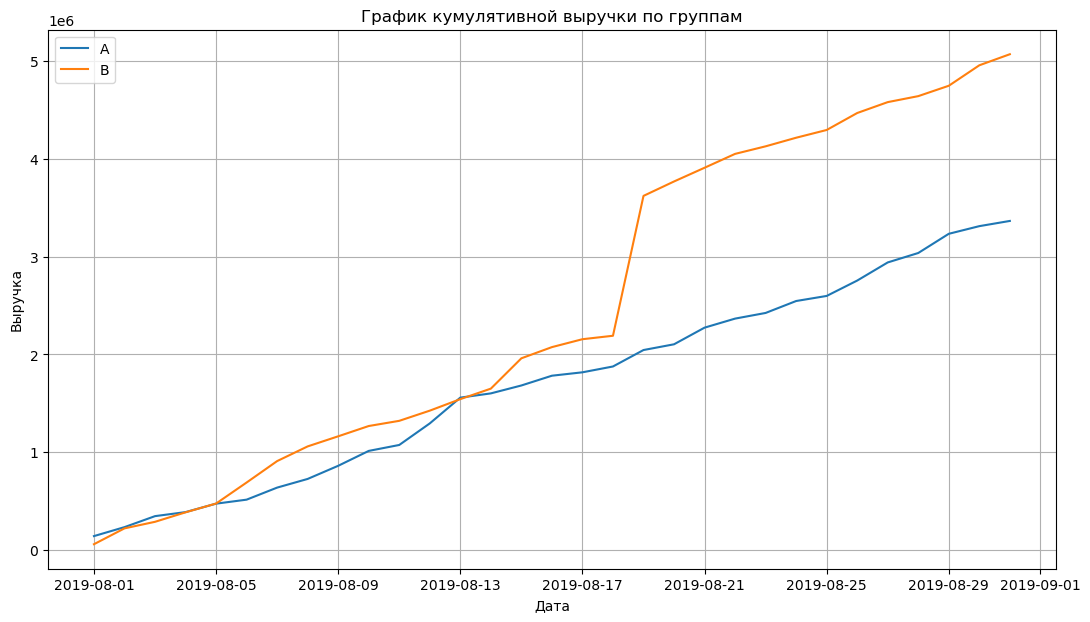

In [14]:
plt.figure(figsize=(13,7))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], 
         cumulativeRevenueA['revenue'], 
         label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], 
         cumulativeRevenueB['revenue'], 
         label='B')

plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid(True)
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. В группе B в середине эксперимента видим резкий рост выручки.

#### 2.2 Строим график кумулятивного среднего чека по группам. <a id='2.2'></a>

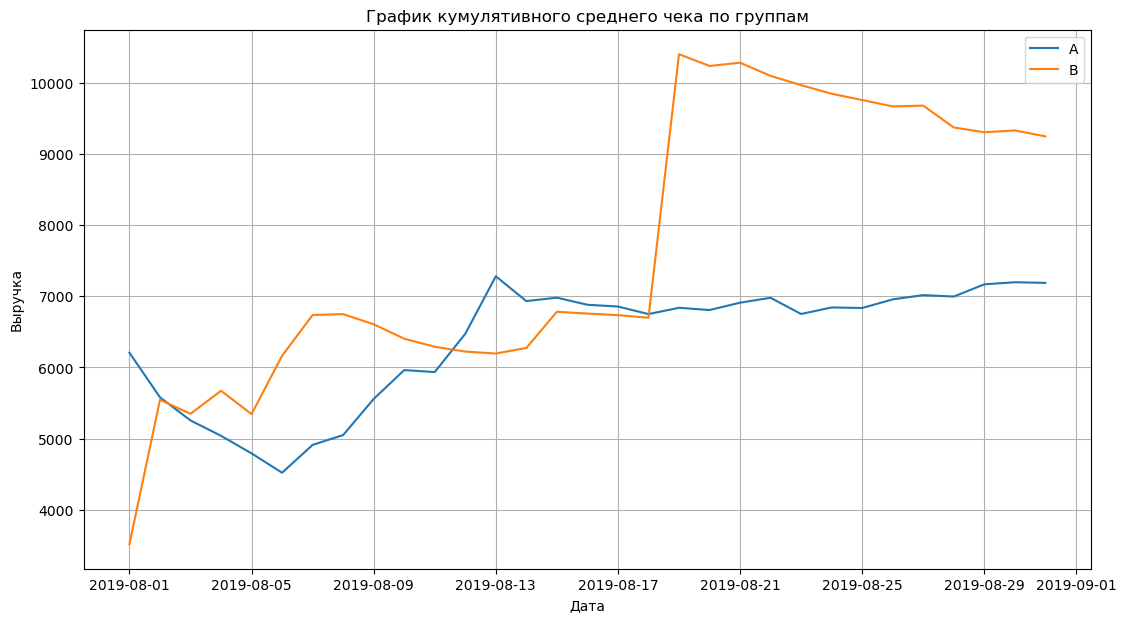

In [15]:
plt.figure(figsize=(13,7))
plt.plot(cumulativeRevenueA['date'], 
         cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], 
         label='A'
        )
plt.plot(cumulativeRevenueB['date'], 
         cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], 
         label='B'
        )
plt.legend() 
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid(True)
plt.show()

В группе B видим резкое увеличение среднего чека в середине эксперимента, с последующим его снижением. Скорее всего, крупный заказ.

#### 2.3 Строим график относительного изменения кумулятивного среднего чека группы B к группе A. <a id='2.3'></a>

In [16]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B']
                                                  )

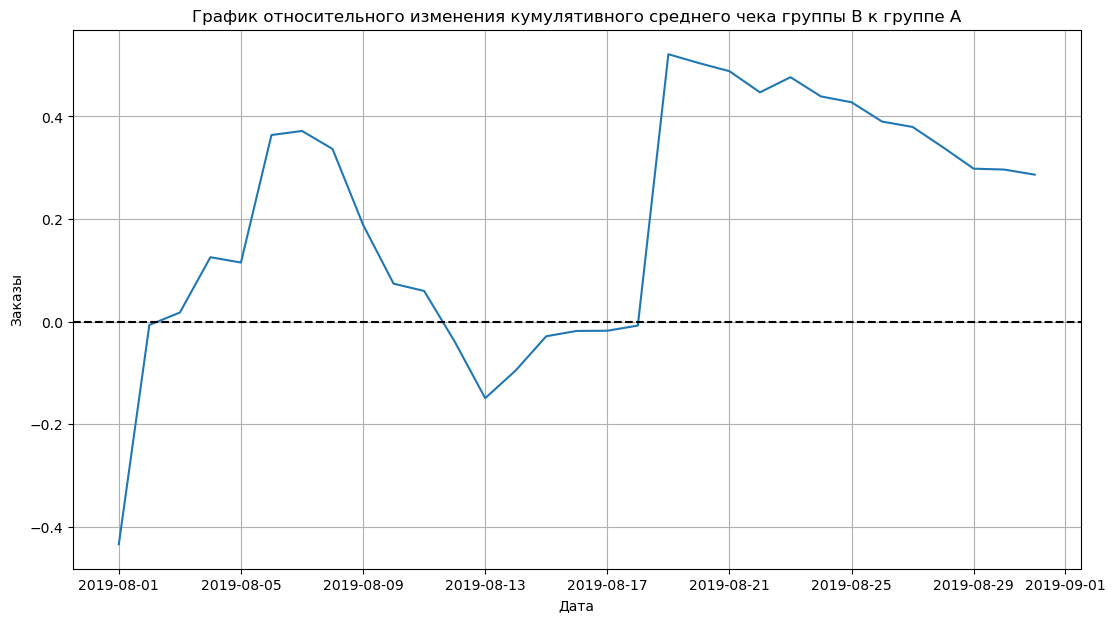

In [17]:
plt.figure(figsize=(13,7))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1
        )

# добавляем ось X
plt.axhline(y=0, 
            color='black', 
            linestyle='--'
           )
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.grid(True)
plt.show()

В середине эксперимента кумулятивный средний чек группы B по отношению к группе A сначала резко снижается, затем, так же резко вырастает. Стоит проанализировать данные на аномалии.

#### 2.4 Строим график кумулятивного среднего количества заказов на посетителя по группам. <a id='2.4'></a>

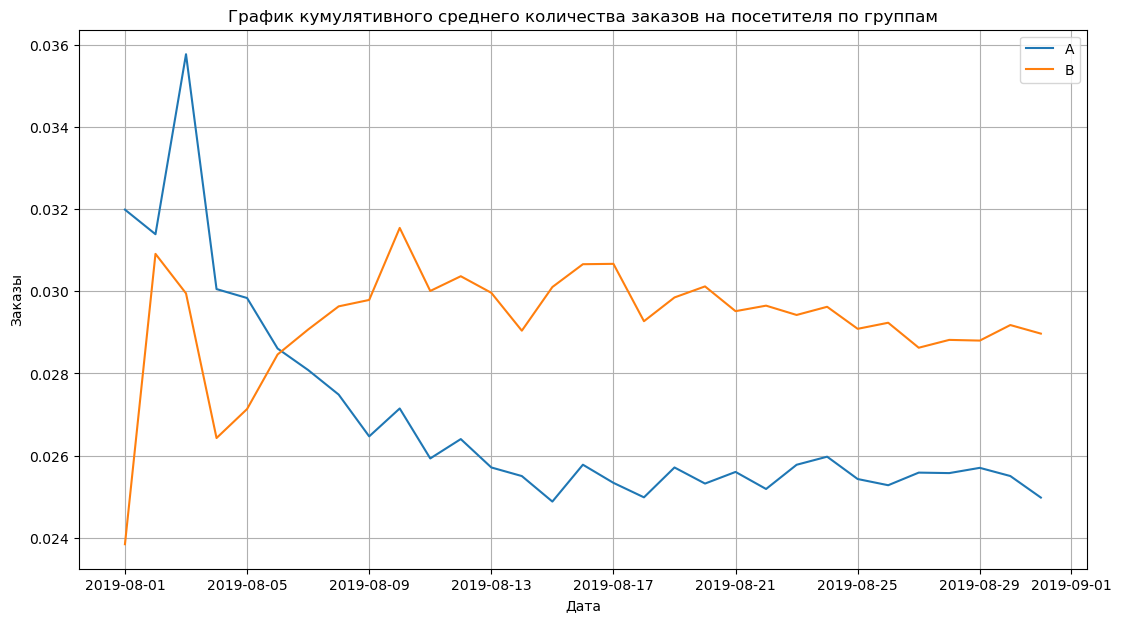

In [18]:
plt.figure(figsize=(13,7))
plt.plot(cumulativeRevenueA['date'], 
         cumulativeRevenueA['orders']/cumulativeRevenueA['visitors'], 
         label='A'
        )
plt.plot(cumulativeRevenueB['date'], 
         cumulativeRevenueB['orders']/cumulativeRevenueB['visitors'], 
         label='B'
        )
plt.legend() 
plt.grid(True)
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.show()

К концу эксперимента кумулятивное среднее количество заказов выровнялось в обеих группах. В группе B это значение ниже, чем в группе A на протяжении всего эксперимента.

#### 2.5 Строим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. <a id='2.5'></a>

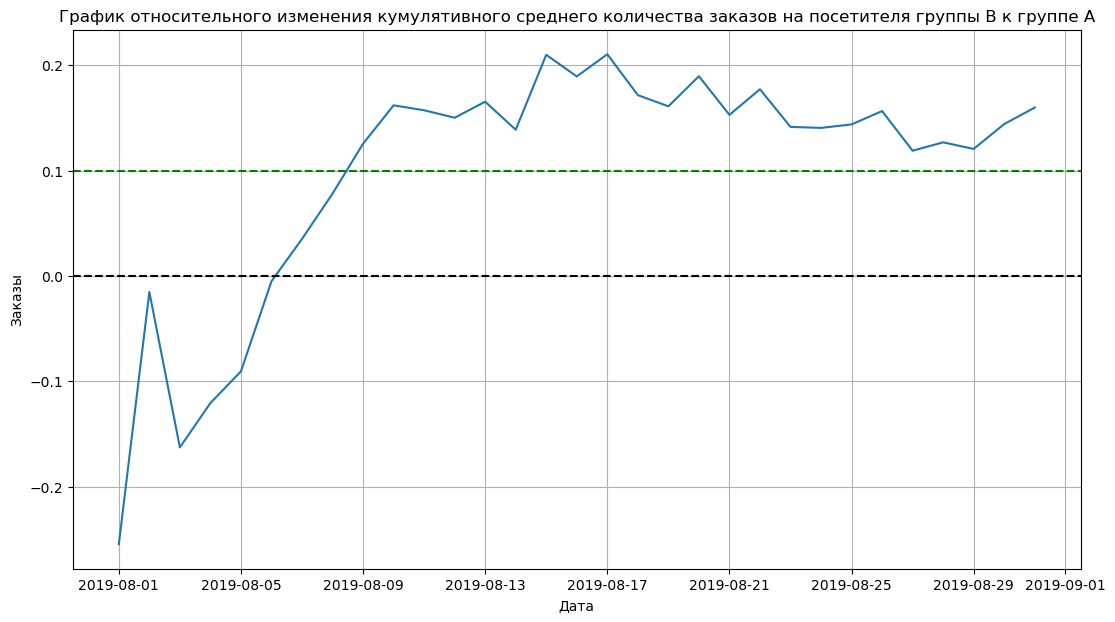

In [19]:
plt.figure(figsize=(13,7))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['ordersB']/mergedCumulativeRevenue['visitorsB'])/
         (mergedCumulativeRevenue['ordersA']/mergedCumulativeRevenue['visitorsA'])-1
        )

# добавляем ось X
plt.axhline(y=0, 
            color='black', 
            linestyle='--'
           )
plt.axhline(y=0.1, 
            color='green', 
            linestyle='--'
           )
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.grid(True)
plt.show()

Кумулятивное среднее количество заказов на посетителя группы B оносительно группы A растет на протяжении эксперимента.

#### 2.6 Строим точечный график количества заказов по пользователям  <a id='2.6'></a>

In [20]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})

ordersByUsers.columns = ['userId', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,userId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


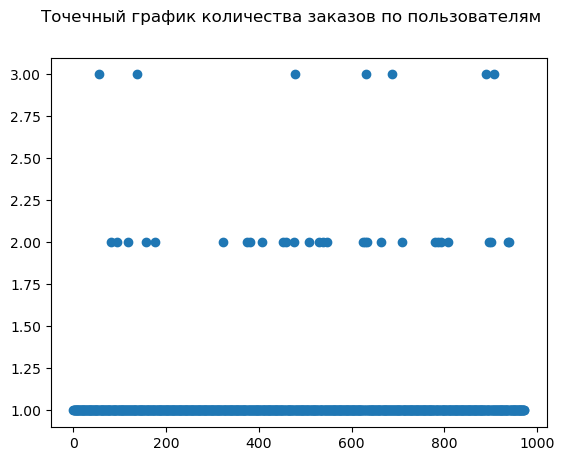

In [21]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, 
            ordersByUsers['orders']
           ) 
plt.suptitle('Точечный график количества заказов по пользователям')
plt.show()

Несколько пользователей совершили 2 и 3 заказа.

#### 2.7 Считаем 95-й и 99-й перцентили количества заказов на пользователя. Определяем границу аномальных пользователей. <a id='2.7'></a>

In [22]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 1., 2.])

95% покупателей совершили не более 1 заказа. Примем это количество за границу аномального количества заказов.

#### 2.8 Строим точечный график стоимостей заказов <a id='2.8'></a>

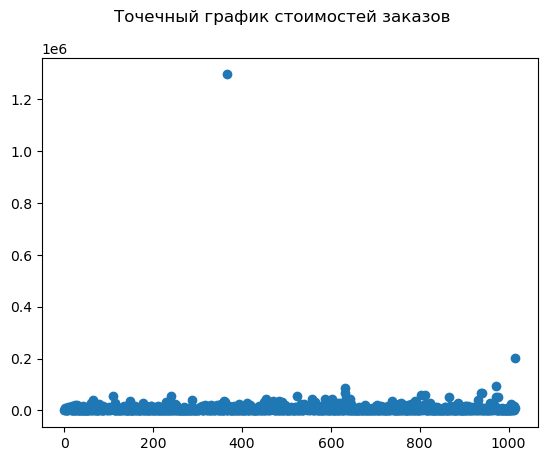

In [23]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, 
            orders['revenue']
           )
plt.suptitle('Точечный график стоимостей заказов')
plt.show()

Видим один очень дорогой заказ, стоимостью более 1,2 млн. Определенно, его можно считать аномальным значением. Также, выбивается один заказ стоимостью около 200 тыс.

#### 2.9 Считаем 95-й и 99-й перцентили стоимости заказов. Определяем границу аномальных пользователей. <a id='2.9'></a>

In [24]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

У 95% заказов сумма не превышает 26,8 тыс. Эта сумма и будет границей аномальных заказов.

#### 2.10 Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным  <a id='2.10'></a>

Сформулируем гипотезы по «сырым» данным. 
>$H_0$ - Различий в среднем количестве заказов между группами по «сырым» данным нет. 
>
>$H_1$ - Различия в среднем количестве заказов между группами по «сырым» данным есть.

In [25]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [26]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'], 
                     pd.Series(0, 
                               index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), 
                               name='orders')], 
                    axis=0
                   )

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, 
                               index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), 
                               name='orders')], 
                    axis=0
                   )

In [27]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative="two-sided")[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.011
0.160


P-value = 0.011, меньше 0.05. Значит, есть основания отвергнуть нулевую гипотезу. Относительное среднее количество заказов группы B к группе A выше на 16%.

#### 2.11 Считаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным  <a id='2.11'></a>

Сформулируем гипотезы по «сырым» данным.

>$H_0$ - Различий в среднем чеке между группами по «сырым» данным нет.
>
>$H_1$ - Различия в среднем чеке между группами по «сырым» данным есть. 

In [28]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'], 
                                          alternative="two-sided")[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean() / 
                       orders[orders['group']=='A']['revenue'].mean()-1))

0.829
0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. В данном случае, средний чек группы B на 28,7% выше среднего чека группы A.

#### 2.12 Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным <a id='2.12'></a>

Сформулируем гипотезы по «очищенным» данным.

>$H_0$ - Различий в среднем количестве заказов между группами по «очищенным» данным нет.
>
>$H_1$ - Различия в среднем количестве заказов между группами по «очищенным» данным есть.

In [29]:
#создадим датасет с аномальными пользователями
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [30]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [31]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, 
                                          sampleBFiltered, 
                                          alternative="two-sided")[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/
                       sampleAFiltered.mean()-1))

0.016
0.174


Изменения, по сравнению с предыдущим шагом с сырыми данными, незначительны. Нулевая гипотеза отвергается. Среднее количество заказов на посетителя в группе B по очищенным данным увеличилось до 17,4% относительно группы A

#### 2.13 Считаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным  <a id='2.13'></a>

Сформулируем гипотезы по «очищенным» данным.

>$H_0$ - Различий в среднем чеке между группами по «очищенным» данным нет.
>
>$H_1$ - Различия в среднем чеке между группами по «очищенным» данным есть.

In [32]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers))
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers))
                )
            ]['revenue'],
            alternative="two-sided"
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers))
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers))
            )
        ]['revenue'].mean()
        - 1
    )
)

0.727
-0.034


P-value по прежнему намного больше 0.05. Причин отвергать нулевую гипотезу нет. Однако, средний чек группы B теперь на 3,4% меньше среднего чека группы A.

#### 2.14 Принимаем решение по результатам теста  <a id='2.14'></a>

Статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий есть: группа B эффективнее группы А;

Статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий нет;

В даном случае, тест следует остановить, признать группу B наиболее эффективной и внедрять изменения. Продолжать смысла нет, т.к. как вероятность, что при имеющихся данных сегмент B на самом деле хуже, или, как минимум, не лучше сегмента A — практически нулевая.

## Вывод:  <a id='3'></a>

В ходе проведения A/B теста проверено две гипотезы:

* Нулевая: различий в среднем количестве заказов между группами нет.
* Альтернативная: различия в среднем между группами есть.

Данная гипотеза была отвергнута, значение P-value по очищененм данным составило 0.016. Среднее количество заказов на посетителя в группе B по очищенным данным на 17,4% выше, относительно группы A

- Нулевая: различий в среднем чеке между группами нет.
- Альтернативная: различия в среднем чеке между группами есть.

Значение P-value по очищененм данным составило 0.727. Причин отвергать нулевую гипотезу нет.

После анализа имеющихся данных эксперимент следует остановить, признать группу B наиболее эффективной с точки зрения увеличения среднего количества заказов. Различий в среднем чеке между группами нет.